# A-Band Fitting Using HAPI MultiSpectrum fitting
* Loads packages
* Defines Spectra and Dataset
* Generates parameter and baseline linelists
* Fits Data

In [136]:
## Multi- Spectrum Fitting by Segment

import numpy as np
#import numpy.ma as ma
import pandas as pd
import qgrid
import os
#from lmfit import minimize, Parameters, report_fit, Model, Minimizer
#from lmfit.models import GaussianModel, LinearModel, Model, VoigtModel
import matplotlib.pyplot as plt
from matplotlib import gridspec
#from scipy import interpolate

import sys
# sys.path.append(r'C:\Users\ema3\Documents\MATS\MATS')# set location of HAPI.py module

%matplotlib inline
from MATS.hapi import *
from MATS.MATS import *

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")


## Load Spectrum

In [137]:
from MATS.exampledata import exampledata

In [244]:
exampledata._cache = {}

In [275]:
PARAM_LINELIST = exampledata.O2_ABand_Drouin_2017_linelist

In [311]:
np.random.seed(0)

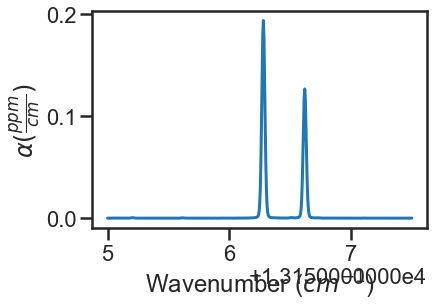

In [312]:
#Generic Fit Parameters
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
sample_molefraction = {7 :0.002022}
wave_min = 13155 #cm-1
wave_max = 13157.5 #cm-1
wave_space = 0.005 #cm-1
baseline_terms = [0] #polynomial baseline coefficients where the index is equal to the coefficient order



#Error Sources
##SNR
SNR = 10000

## Wavenumber - adds gaussian noise of given absolute magniture
wave_error = 5e-5

## Temperature
'''
possible keys include 'bias', 'function', and 'params'.  
The bias indicates the absolute bias in Celsius of the temperature reading, which will be added to the input temperature.  
Function can be 'linear' with params 'm' and 'b' or 'sine' with parameters 'amp', 'freq', and 'phase'.  
These define a function that is added to both the bias and set temperature as a function of the wavenumber. 
Note: if 'function' key is not equal to None, then there also needs to be a params key to define the function.
'''
temperature_err =  {'bias': 0.01, 'function': None, 'params': {}}

## Pressure
'''
possible keys include bias, function, and params.  
The bias indicates the percent bias in of the pressure reading, which will be added to the input pressure.  
Function can be 'linear' with params 'm' and 'b' or 'sine' with parameters 'amp', 'freq', and 'phase'.  
These define a function that is added to both the bias and set pressure as a function of the wavenumber. 
Note: if 'function' key is not equal to None, then there also needs to be a params key to define the function.
'''
pressure_err = {'per_bias': 0.01, 'function': None, 'params': {}}
##Mole Fraction
'''
percent error in the mole fraction of each molecule to be simulated in the spectrum
'''
molefraction_err = {7:0.01}

tmp = PARAM_LINELIST
spec_1 =  simulate_spectrum(tmp, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 20, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '20_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)

spec_2 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 40, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '40_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)
spec_3 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 60, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '60_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)
spec_4 =  simulate_spectrum(PARAM_LINELIST, wave_min, wave_max, wave_space, wave_error = wave_error, 
                        SNR = SNR, baseline_terms = baseline_terms, temperature = 25, temperature_err = temperature_err, pressure = 80, 
                        pressure_err = pressure_err, 
                        wing_cutoff = 50,  wing_method = 'wing_cutoff', filename = '80_torr', molefraction = sample_molefraction, molefraction_err = molefraction_err,
                        natural_abundance = True, nominal_temperature = 296, IntensityThreshold = 1e-30, num_segments = 1)





spec_1.plot_wave_alpha()

## Construct Dataset

In [313]:
#Add all spectrum to a Dataset object
SPECTRA = Dataset([spec_1, spec_2, spec_3, spec_4], 'Line Intensity', baseline_order = order_baseline_fit)

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()
#BASE_LINELIST = pd.read_csv('Line Intensity_baseline_paramlist.csv')





## Generate Fit Parameter Files

In [314]:
#os.chdir(path)
# Set-up for Fitting
#lineprofile = 'NGP' #VP, SDVP, NGP, SDNGP, HTP


  

FITPARAMS = Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = True, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_freq= False, vary_etalon_phase= True, 
                                         vary_pressure = False, vary_temperature = False)





,Pressure,Pressure_err,Pressure_vary,Segment Number,Temperature,Temperature_err,Temperature_vary,baseline_a,baseline_a_err,baseline_a_vary,molefraction_O2,molefraction_O2_err,molefraction_O2_vary,x_shift,x_shift_err,x_shift_vary
Spectrum Number,,,,,,,,,,,,,,,,
1.0,0.026316,0,False,0.0,298.15,0,False,-9.911083e-08,0,True,0.002022,0,False,0.0,0,False
2.0,0.052632,0,False,0.0,298.15,0,False,-1.925248e-05,0,True,0.002022,0,False,0.0,0,False
3.0,0.078947,0,False,0.0,298.15,0,False,-4.833483e-05,0,True,0.002022,0,False,0.0,0,False
4.0,0.105263,0,False,0.0,298.15,0,False,2.199691e-05,0,True,0.002022,0,False,0.0,0,False


In [316]:
#os.chdir(path)   
fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity, 
                baseline_limit = False, baseline_limit_factor = 10, 
                molefraction_limit = False, molefraction_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = False, x_shift_limit_magnitude = 0.5, 
                nu_limit = False, nu_limit_magnitude = 0.1, 
                sw_limit = False, sw_limit_factor = 2, 
                gamma0_limit = False, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = False, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = False, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = False, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = False, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params = fit_data.generate_params()




#print (params)

#add_expr_params(self, params, param_name, expr)

result = fit_data.fit_data(params, wing_cutoff = 25, wing_wavenumbers = 1)

In [308]:
def params_to_frame(params):
    df = pd.DataFrame([
        dict(name=v.name, value=v.value, init_value=v.init_value, min=v.min, max=v.max, vary=v.vary, stderr=v.stderr)
        for k, v in params.items()
    ]).set_index('name')
    return df

In [317]:
out_df2 = params_to_frame(result.params)

In [318]:
pd.testing.assert_frame_equal(out_df, out_df2)

Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_0           0.02632     -inf      inf        0    False     None     None
Pressure_2_0           0.05263     -inf      inf        0    False     None     None
Pressure_3_0           0.07895     -inf      inf        0    False     None     None
Pressure_4_0            0.1053     -inf      inf        0    False     None     None
SD_delta_air_line_12         0     -inf      inf        0    False     None     None
SD_delta_air_line_15         0     -inf      inf        0    False     None     None
SD_delta_air_line_27         0     -inf      inf        0    False     None     None
SD_delta_air_line_28         0     -inf      inf        0    False     None     None
SD_delta_air_line_3          0     -inf      inf        0    False     None     None
SD_gamma_air_line_12   0.08373        0      inf 0.0008903     True     None     None
SD_gamma_air_line_15   0.09303        0      inf  0.00127     

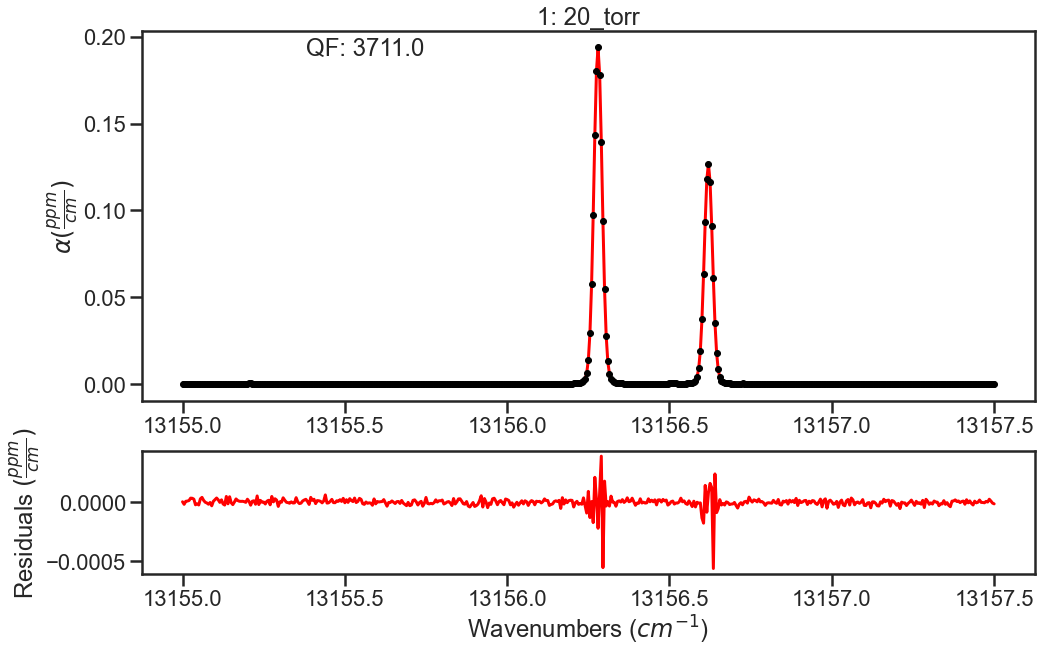

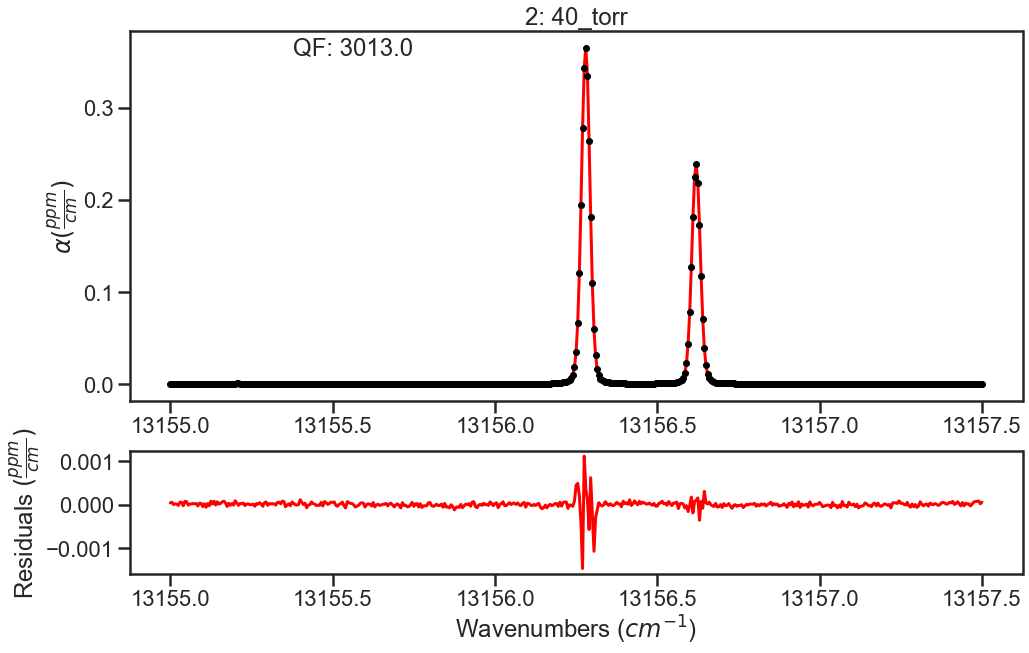

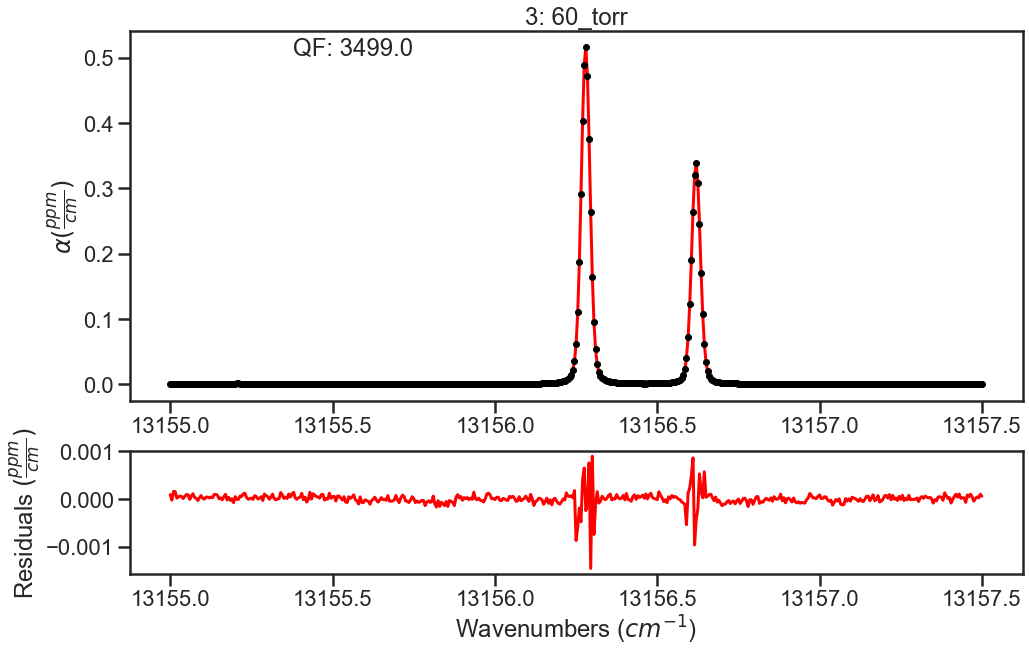

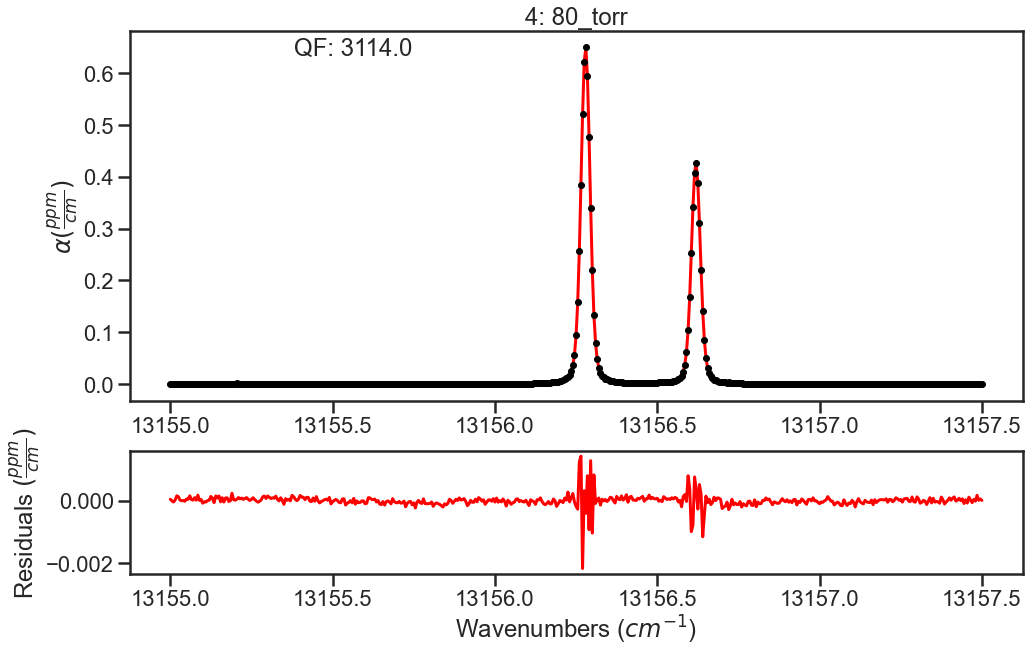

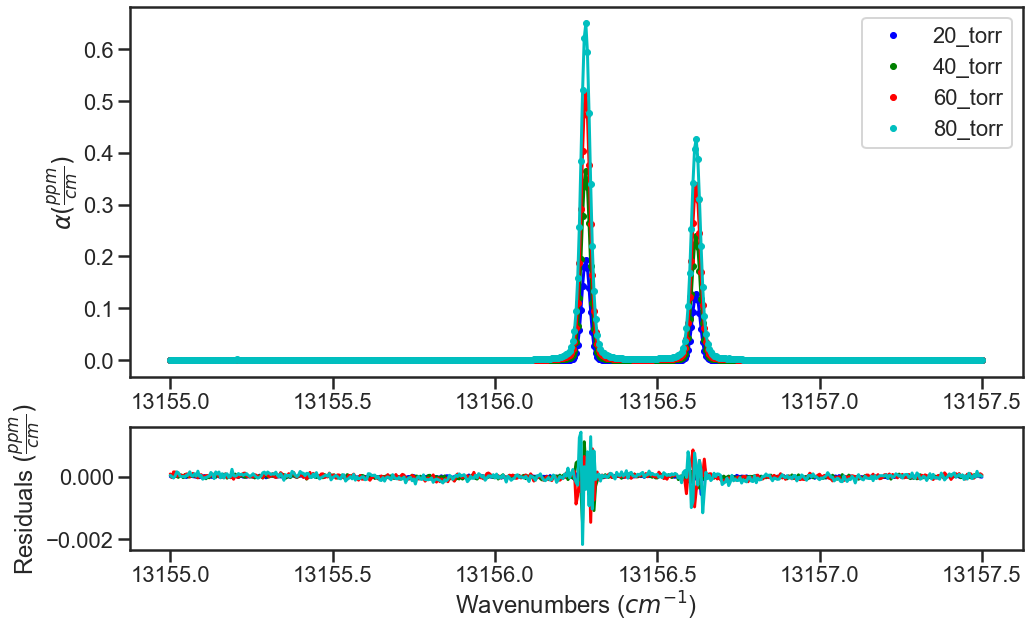

In [297]:
print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()

# limited number of spectra

In [151]:
#Add all spectrum to a Dataset object
X = [spec_1, spec_2]
SPECTRA2 = Dataset(X, 'Line Intensity', baseline_order = order_baseline_fit)

In [152]:
#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST2 = SPECTRA2.generate_baseline_paramlist()
##BASE_LINELIST = pd.read_csv('Line Intensity_baseline_paramlist.csv')

In [156]:
#os.chdir(path)
# Set-up for Fitting
#lineprofile = 'NGP' #VP, SDVP, NGP, SDNGP, HTP


  

FITPARAMS2 = Generate_FitParam_File(SPECTRA2, PARAM_LINELIST, 
                                    BASE_LINELIST2, lineprofile = 'SDVP', 
                                    linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS2.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS2.generate_fit_baseline_linelist(vary_baseline = True, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_freq= False, vary_etalon_phase= True, 
                                         vary_pressure = False, vary_temperature = False)

,Pressure,Pressure_err,Pressure_vary,Segment Number,Temperature,Temperature_err,Temperature_vary,baseline_a,baseline_a_err,baseline_a_vary,molefraction_O2,molefraction_O2_err,molefraction_O2_vary,x_shift,x_shift_err,x_shift_vary
Spectrum Number,,,,,,,,,,,,,,,,
1.0,0.026316,0,False,0.0,298.15,0,False,0.000031,0,True,0.002022,0,False,0.0,0,False
2.0,0.052632,0,False,0.0,298.15,0,False,0.000020,0,True,0.002022,0,False,0.0,0,False


Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_0           0.02632     -inf      inf        0    False     None     None
Pressure_2_0           0.05263     -inf      inf        0    False     None     None
SD_delta_air_line_12         0     -inf      inf        0    False     None     None
SD_delta_air_line_15         0     -inf      inf        0    False     None     None
SD_delta_air_line_27         0     -inf      inf        0    False     None     None
SD_delta_air_line_28         0     -inf      inf        0    False     None     None
SD_delta_air_line_3          0     -inf      inf        0    False     None     None
SD_gamma_air_line_12   0.08463        0      inf 0.002296     True     None     None
SD_gamma_air_line_15    0.1101        0      inf 0.003497     True     None     None
SD_gamma_air_line_27      0.09        0      inf        0    False     None     None
SD_gamma_air_line_28       0.1        0      inf        0    Fa

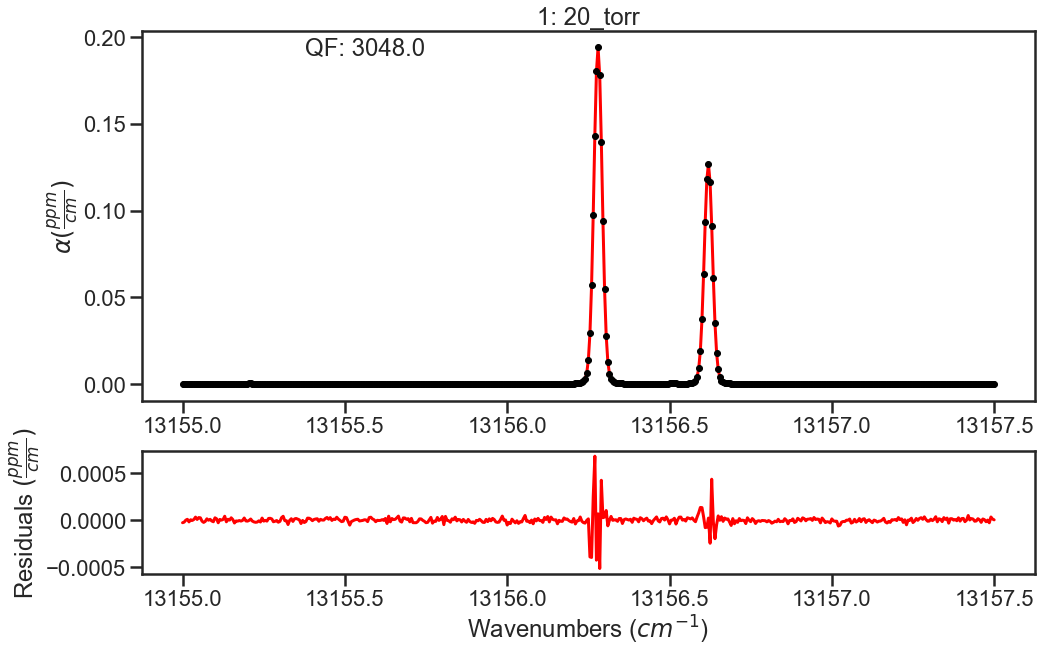

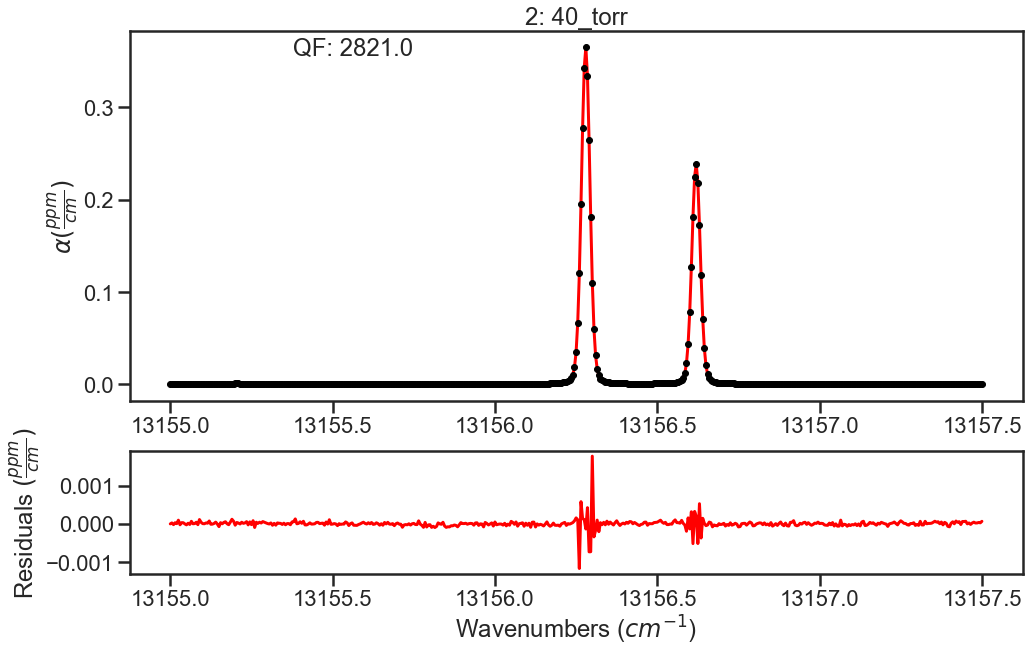

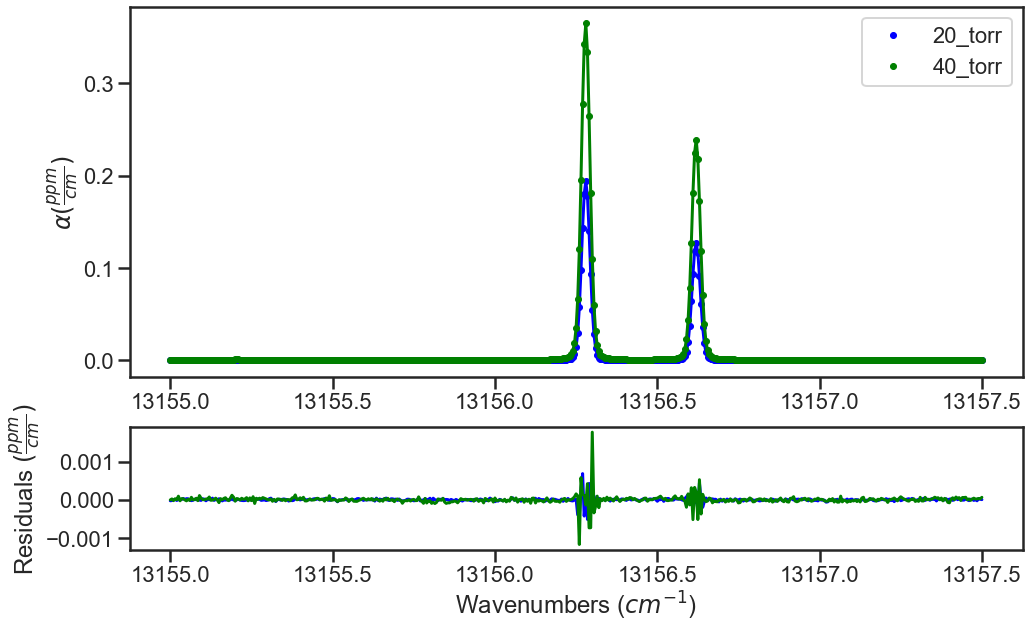

In [157]:
#os.chdir(path)   
fit_data2 = Fit_DataSet(SPECTRA2,'Baseline_LineList', 'Parameter_LineList',
                        minimum_parameter_fit_intensity = Fit_Intensity, 
                baseline_limit = False, baseline_limit_factor = 10, 
                molefraction_limit = False, molefraction_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = False, x_shift_limit_magnitude = 0.5, 
                nu_limit = False, nu_limit_magnitude = 0.1, 
                sw_limit = False, sw_limit_factor = 2, 
                gamma0_limit = False, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = False, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = False, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = False, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = False, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params2 = fit_data2.generate_params()




#print (params)

#add_expr_params(self, params, param_name, expr)

result2 = fit_data2.fit_data(params2, wing_cutoff = 25, wing_wavenumbers = 1)
print (result2.params.pretty_print())

fit_data2.residual_analysis(result2, indv_resid_plot=True)
fit_data2.update_params(result2)
SPECTRA2.generate_summary_file(save_file = True)
SPECTRA2.plot_model_residuals()




In [200]:
def params_to_frame(params):
    df = pd.DataFrame([
        dict(name=v.name, value=v.value, init_value=v.init_value, min=v.min, max=v.max, vary=v.vary, stderr=v.stderr)
        for k, v in params.items()
    ]).set_index('name')
    return df

In [201]:
a = params_to_frame(params)
b = params_to_frame(params2)

In [208]:
(a.value - b.value).dropna()

name
Pressure_1_0            0.0
Pressure_2_0            0.0
SD_delta_air_line_12    0.0
SD_delta_air_line_15    0.0
SD_delta_air_line_27    0.0
                       ... 
y_air_296_line_12       0.0
y_air_296_line_15       0.0
y_air_296_line_27       0.0
y_air_296_line_28       0.0
y_air_296_line_3        0.0
Name: value, Length: 65, dtype: float64

In [210]:
a = params_to_frame(result.params)
b = params_to_frame(result2.params)

In [223]:
(a - b)[['value','init_value','stderr']].dropna().query('value !=0')

,value,init_value,stderr
name,,,
SD_gamma_air_line_12,-1.147968e-02,-0.006708,-1.479829e-03
SD_gamma_air_line_15,-1.598388e-02,-0.005786,-2.273793e-03
baseline_a_1_0,-4.272315e-07,-0.000028,1.413457e-06
baseline_a_2_0,-1.429902e-06,-0.000007,1.212497e-06
gamma0_air_line_12,-2.010906e-04,-0.000233,-8.718576e-05
gamma0_air_line_15,-1.288807e-04,-0.000125,-1.336175e-04
nu_1_line_12,-1.049448e-07,0.000003,1.377286e-06
nu_1_line_15,-6.357186e-08,0.000014,2.108078e-06
nu_2_line_12,-1.806184e-07,-0.000011,7.537161e-07


In [217]:
pd.merge(*[x[['value','stderr']] for x in [a,b]], left_index=True, right_index=True)

,value_x,stderr_x,value_y,stderr_y
name,,,,
Pressure_1_0,0.026316,0.000000,0.026316,0.000000
Temperature_1_0,298.150000,0.000000,298.150000,0.000000
baseline_a_1_0,0.000003,0.000006,0.000003,0.000005
molefraction_O2_1_0,0.002022,0.000000,0.002022,0.000000
x_shift_1_0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
nuVC_air_line_28,0.000000,0.000000,0.000000,0.000000
SD_gamma_air_line_28,0.100000,0.000000,0.100000,0.000000
SD_delta_air_line_28,0.000000,0.000000,0.000000,0.000000


In [215]:
a.join(b, lsuffix='', rsuffix='_2')

,value,init_value,min,max,vary,stderr,value_2,init_value_2,min_2,max_2,vary_2,stderr_2
name,,,,,,,,,,,,
Pressure_1_0,0.026316,0.026316,-inf,inf,False,0.000000,0.026316,0.026316,-inf,inf,False,0.000000
Temperature_1_0,298.150000,298.150000,-inf,inf,False,0.000000,298.150000,298.150000,-inf,inf,False,0.000000
baseline_a_1_0,0.000003,0.000003,-inf,inf,True,0.000006,0.000003,0.000031,-inf,inf,True,0.000005
molefraction_O2_1_0,0.002022,0.002022,-inf,inf,False,0.000000,0.002022,0.002022,-inf,inf,False,0.000000
x_shift_1_0,0.000000,0.000000,-inf,inf,False,0.000000,0.000000,0.000000,-inf,inf,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
nuVC_air_line_28,0.000000,0.000000,-inf,inf,False,0.000000,0.000000,0.000000,-inf,inf,False,0.000000
SD_gamma_air_line_28,0.100000,0.100000,0.0,inf,False,0.000000,0.100000,0.100000,0.0,inf,False,0.000000
SD_delta_air_line_28,0.000000,0.000000,-inf,inf,False,0.000000,0.000000,0.000000,-inf,inf,False,0.000000


In [213]:
pd.merge((a, b), left_index=True, right_index=True)

TypeError: merge() missing 1 required positional argument: 'right'

In [168]:
for k, v in params.items():
    break

In [171]:
for k, r in result.params.items():

    break

In [182]:
r = result.params['baseline_a_1_0']

In [186]:
v.stderr

In [175]:
params

name,value,initial value,min,max,vary
Pressure_1_0,0.02631579,0.0263157894736842,-inf,inf,False
Temperature_1_0,298.150000,298.15,-inf,inf,False
baseline_a_1_0,2.9719e-06,2.9719215990152512e-06,-inf,inf,True
molefraction_O2_1_0,0.00202200,0.002022,-inf,inf,False
x_shift_1_0,0.00000000,0.0,-inf,inf,False
Pressure_2_0,0.05263158,0.0526315789473684,-inf,inf,False
Temperature_2_0,298.150000,298.15,-inf,inf,False
baseline_a_2_0,1.3544e-05,1.3544228176162892e-05,-inf,inf,True
molefraction_O2_2_0,0.00202200,0.002022,-inf,inf,False
x_shift_2_0,0.00000000,0.0,-inf,inf,False


In [176]:
result.params

/Users/wpk/miniforge3/envs/MATS-env/lib/python3.8/site-packages/lmfit/printfuncs.py:321: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))
/Users/wpk/miniforge3/envs/MATS-env/lib/python3.8/site-packages/lmfit/printfuncs.py:321: RuntimeWarning: invalid value encountered in long_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))


name,value,standard error,relative error,initial value,min,max,vary
Pressure_1_0,0.02631579,0.00000000,(0.00%),0.0263157894736842,-inf,inf,False
Temperature_1_0,298.150000,0.00000000,(0.00%),298.15,-inf,inf,False
baseline_a_1_0,2.9801e-06,6.1063e-06,(204.90%),2.9719215990152512e-06,-inf,inf,True
molefraction_O2_1_0,0.00202200,0.00000000,(0.00%),0.002022,-inf,inf,False
x_shift_1_0,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False
Pressure_2_0,0.05263158,0.00000000,(0.00%),0.0526315789473684,-inf,inf,False
Temperature_2_0,298.150000,0.00000000,(0.00%),298.15,-inf,inf,False
baseline_a_2_0,1.3516e-05,6.1337e-06,(45.38%),1.3544228176162892e-05,-inf,inf,True
molefraction_O2_2_0,0.00202200,0.00000000,(0.00%),0.002022,-inf,inf,False
x_shift_2_0,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False
